In [78]:
import pandapower.networks as pn

net = pn.create_cigre_network_lv()

In [103]:
net.load

,name,bus,p_mw,q_mvar,const_z_percent,const_i_percent,sn_mva,scaling,in_service,type
0,Load R1,2,0.005625,0.062450,0.0,0.0,NaN,1.0,True,wye
1,Load R11,12,0.005625,0.004684,0.0,0.0,NaN,1.0,True,wye
2,Load R15,16,0.005625,0.016237,0.0,0.0,NaN,1.0,True,wye
3,Load R16,17,0.005625,0.017174,0.0,0.0,NaN,1.0,True,wye
4,Load R17,18,0.005625,0.010929,0.0,0.0,NaN,1.0,True,wye
5,Load R18,19,0.005625,0.014676,0.0,0.0,NaN,1.0,True,wye
6,Load I2,22,0.015,0.052678,0.0,0.0,NaN,1.0,True,wye
7,Load C1,24,0.015,0.052307,0.0,0.0,NaN,1.0,True,wye
8,Load C12,35,0.015,0.008718,0.0,0.0,NaN,1.0,True,wye
9,Load C13,36,0.015,0.008718,0.0,0.0,NaN,1.0,True,wye


In [80]:
net.switch.loc[1, "closed"] = False
net.switch.loc[2, "closed"] = False

In [81]:
net.load

,name,bus,p_mw,q_mvar,const_z_percent,const_i_percent,sn_mva,scaling,in_service,type
0,Load R1,2,0.19000,0.062450,0.0,0.0,NaN,1.0,True,wye
1,Load R11,12,0.01425,0.004684,0.0,0.0,NaN,1.0,True,wye
2,Load R15,16,0.04940,0.016237,0.0,0.0,NaN,1.0,True,wye
3,Load R16,17,0.05225,0.017174,0.0,0.0,NaN,1.0,True,wye
4,Load R17,18,0.03325,0.010929,0.0,0.0,NaN,1.0,True,wye
5,Load R18,19,0.04465,0.014676,0.0,0.0,NaN,1.0,True,wye
6,Load I2,22,0.08500,0.052678,0.0,0.0,NaN,1.0,True,wye
7,Load C1,24,0.10800,0.052307,0.0,0.0,NaN,1.0,True,wye
8,Load C12,35,0.01800,0.008718,0.0,0.0,NaN,1.0,True,wye
9,Load C13,36,0.01800,0.008718,0.0,0.0,NaN,1.0,True,wye


In [82]:
import numpy as np
import pandas as pd

import pandapower as pp
import pandapower.control as control
import pandapower.networks as nw
import pandapower.timeseries as timeseries
from pandapower.timeseries.data_sources.frame_data import DFData

In [93]:
# Load and preprocess the CSV file
df = pd.read_csv("load_profile_1111.csv")
df['time'] = pd.to_datetime(df['time'], format='%H:%M:%S').dt.time
df['time_step'] = range(len(df))  # Create a numerical index
df.set_index('time_step', inplace=True)

# Scale the 'mult' column to 5 kW
df['mult'] = df['mult'] * 15/1000

# Ensure that the DataFrame index is an integer starting from 0
ds = DFData(df)

In [94]:
# Set constant loads to 3 kW for all loads except R11 to R18
constant_loads = net.load.index.difference([1, 2, 3, 4, 5])  # Indices of loads R1, I2, C1, C12, C13, C14, C17, C18, C19, C20
net.load.loc[constant_loads, 'p_mw'] = 15/1000

In [95]:
# Initialize ConstControl controller to update values of the loads R11 to R18
profile_loads = net.load.index.intersection([0, 1, 2, 3, 4, 5])  # Indices of loads R11 to R18
const_load = control.ConstControl(net, element='load', element_index=profile_loads,
                                  variable='p_mw', data_source=ds, profile_name=["mult"]*len(profile_loads))


In [96]:
# Run a power flow for the initial condition to check if the network is properly configured
try:
    pp.runpp(net)
except pp.optimal_powerflow.OPFNotConverged:
    print("Initial power flow did not converge. Please check the network configuration.")

In [97]:
# initialising the outputwriter to save data to excel files in the current folder. You can change this to .json, .csv, or .pickle as well
ow = timeseries.OutputWriter(net, output_path="./", output_file_type=".xlsx")
# adding vm_pu of all buses and line_loading in percent of all lines as outputs to be stored
ow.log_variable('res_bus', 'vm_pu')
ow.log_variable('res_line', 'loading_percent')
ow.log_variable('res_load', 'p_mw')
ow.log_variable('res_load', 'q_mvar')


# starting the timeseries simulation for one day -> 96 15 min values.
timeseries.run_timeseries(net)
# now checkout the folders res_bus and res_line in your current working dir

No time steps to calculate are specified. I'll check the datasource of the first controller for avaiable time steps
100%|██████████| 96/96 [00:01<00:00, 63.92it/s]


In [98]:
# Load the results
vm_pu = pd.read_excel('res_bus/vm_pu.xlsx', index_col=0)
loading_percent = pd.read_excel('res_line/loading_percent.xlsx', index_col=0)
load_p_mw = pd.read_excel('res_load/p_mw.xlsx', index_col=0)
load_q_mvar = pd.read_excel('res_load/q_mvar.xlsx', index_col=0)


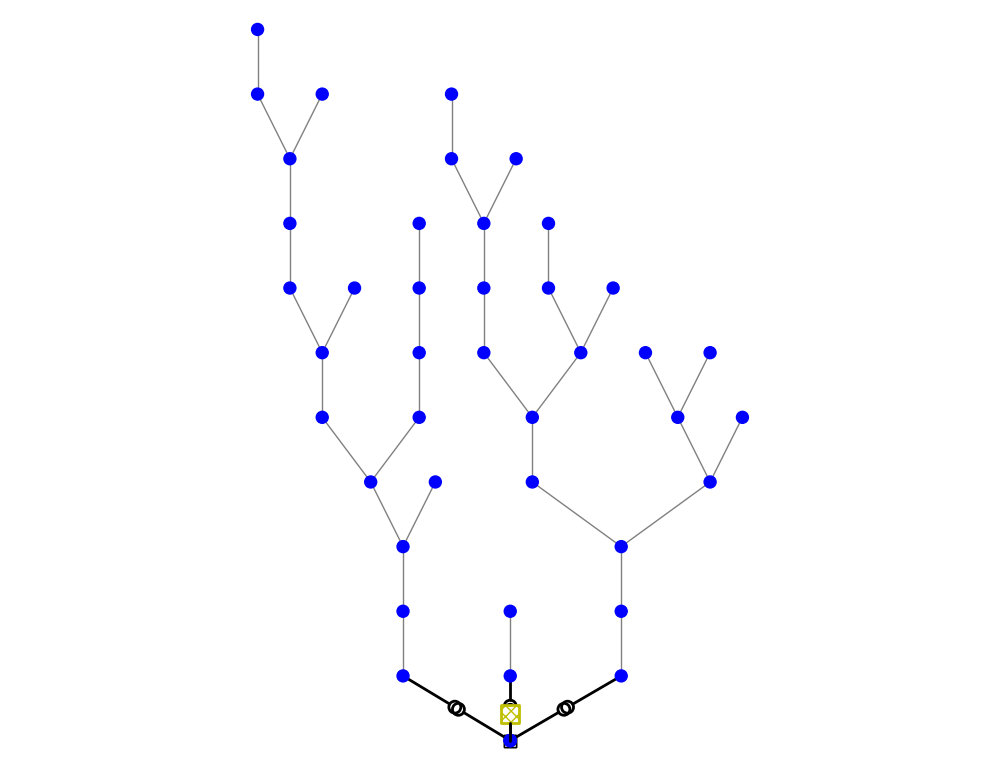

<AxesSubplot:>

In [99]:
import pandapower.plotting as plot
# Plot the grid
plot.simple_plot(net, show_plot=True)

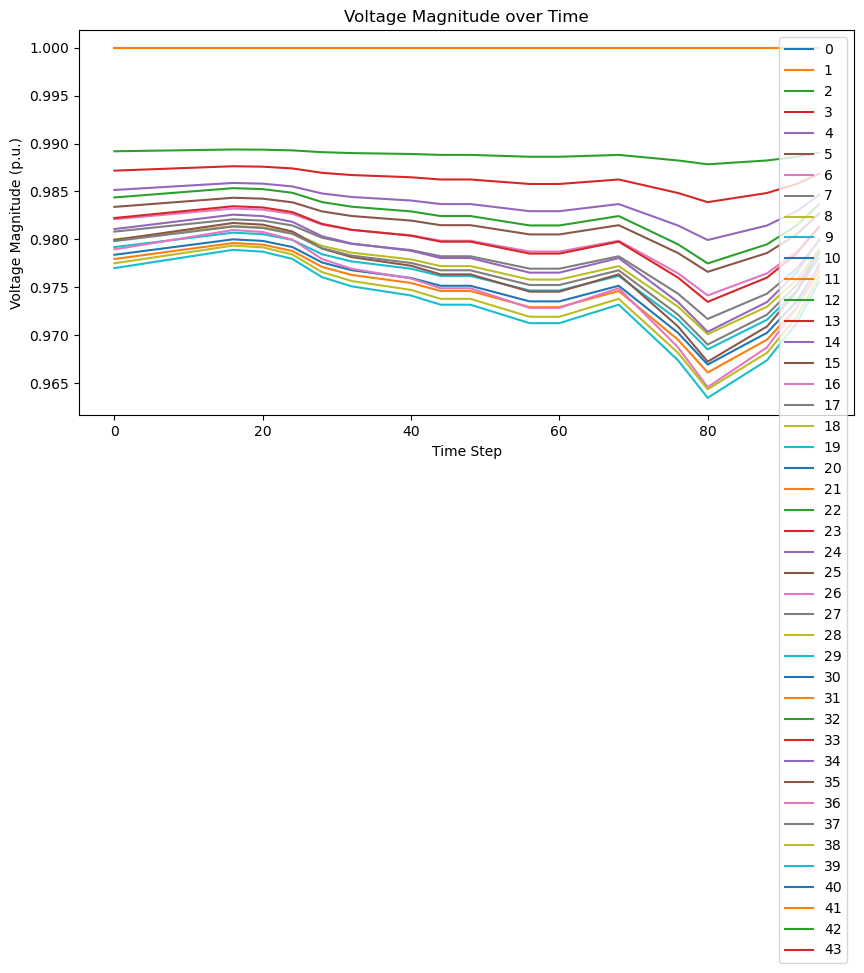

In [100]:
import matplotlib.pyplot as plt
# Generate the plots
plt.figure(figsize=(10, 5))
plt.plot(vm_pu, label=vm_pu.columns)
plt.xlabel('Time Step')
plt.ylabel('Voltage Magnitude (p.u.)')
plt.title('Voltage Magnitude over Time')
plt.legend()
plt.show()


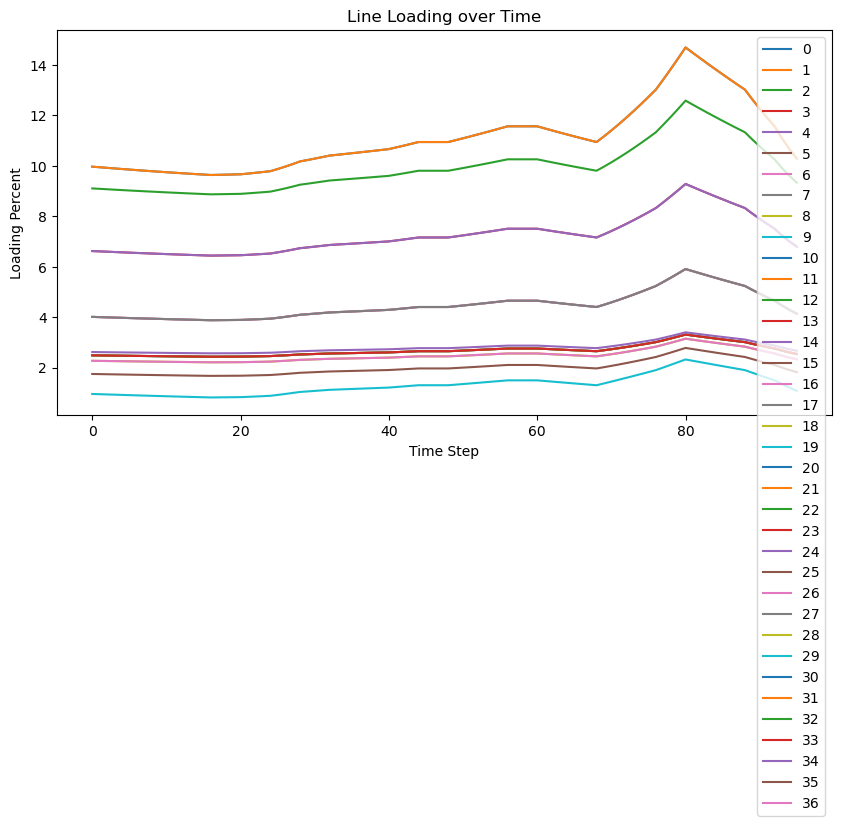

In [101]:

plt.figure(figsize=(10, 5))
plt.plot(loading_percent, label=loading_percent.columns)
plt.xlabel('Time Step')
plt.ylabel('Loading Percent')
plt.title('Line Loading over Time')
plt.legend()
plt.show()

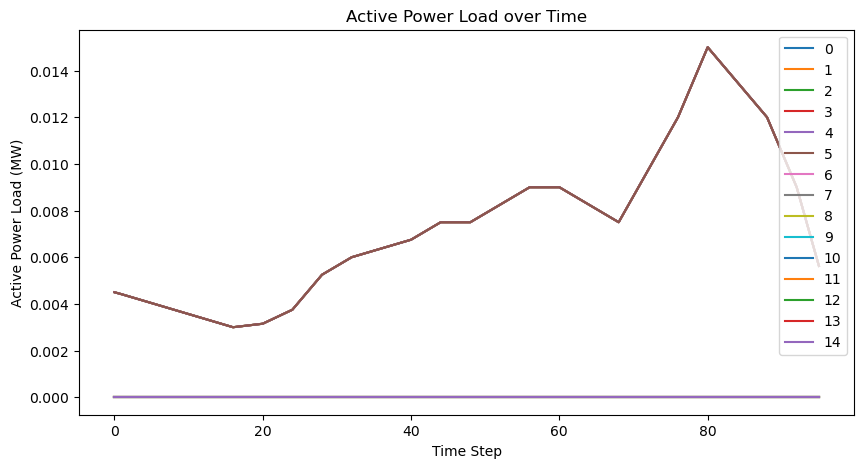

In [102]:
plt.figure(figsize=(10, 5))
plt.plot(load_p_mw, label=load_p_mw.columns)
plt.xlabel('Time Step')
plt.ylabel('Active Power Load (MW)')
plt.title('Active Power Load over Time')
plt.legend()
plt.show()

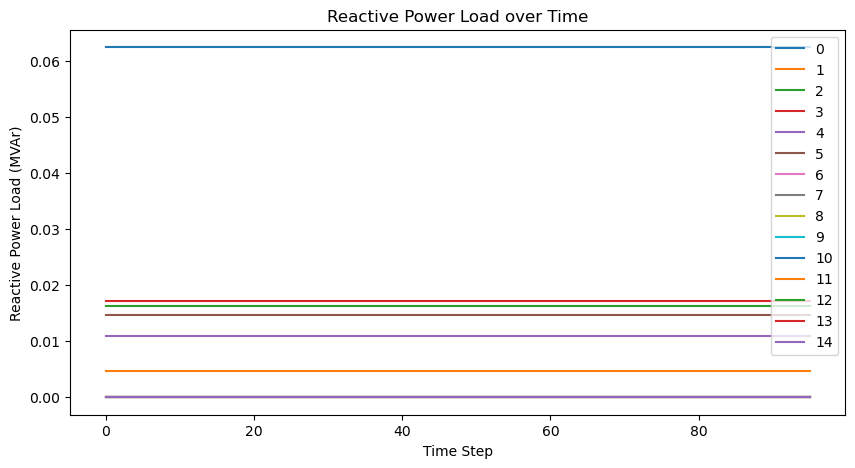

In [57]:
plt.figure(figsize=(10, 5))
plt.plot(load_q_mvar, label=load_q_mvar.columns)
plt.xlabel('Time Step')
plt.ylabel('Reactive Power Load (MVAr)')
plt.title('Reactive Power Load over Time')
plt.legend()
plt.show()